# SARK-110 Time Domain Example

This notebook demonstrates how to use scikit-rf for basic time-domain analysis.

Please ensure that the analyzer is connected to the computer using the USB cable and in Computer Control mode.

In [1]:
from sark110 import *
import skrf as rf 
rf.stylely()
from pylab import *

Enter frequency limits:

In [2]:
fr_start = 100000      # Frequency start in Hz
fr_stop =  230000000   # Frequency stop in Hz
points = 401           # Number of points (resulting step value should be integer)

## Utility functions

In [3]:
def z2vswr(rs: float, xs: float, z0=50 + 0j) -> float:
    gamma = math.sqrt((rs - z0.real) ** 2 + xs ** 2) / math.sqrt((rs + z0.real) ** 2 + xs ** 2)
    if gamma > 0.980197824:
        return 99.999
    swr = (1 + gamma) / (1 - gamma)
    return swr


def z2mag(r: float, x: float) -> float:
    return math.sqrt(r ** 2 + x ** 2)


def z2gamma(rs: float, xs: float, z0=50 + 0j) -> complex:
    z = complex(rs, xs)
    return (z - z0) / (z + z0)

## Connect to the device

In [4]:
sark110 = Sark110()
sark110.open()
sark110.connect()
if not sark110.is_connected:
    print("Device not connected")
    exit(-1)
else:
    print("Device connected")

Device connected


In [5]:
sark110.buzzer()
print(sark110.fw_protocol, sark110.fw_version)

2566 1.5


## Acquire the data

In [6]:
y = []
x = []
rs = [0]
xs = [0]
for i in range(points):  
    freq = int(fr_start + i*(fr_stop-fr_start)/(points-1))
    sark110.measure(freq, rs, xs)
    x.append(freq / 1e9)    # Units in GHz
    y.append(z2gamma(rs[0][0], xs[0][0]))

probe = rf.Network(frequency=x, s=y, z0=50)
# first, extrapolates the measured data to DC
probe_dc = probe.extrapolate_to_dc()
probe_dc.frequency.unit = 'mhz'
print (probe_dc)

1-Port Network: '',  0.0-230.0 MHz, 401 pts, z0=[50.+0.j]


# Plot S11


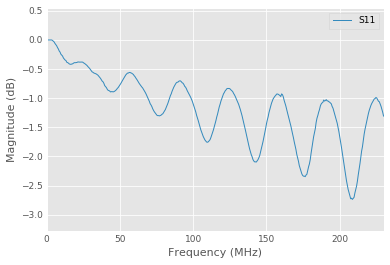

In [7]:
probe_dc.plot_s_db()

# Plot step and impulse response

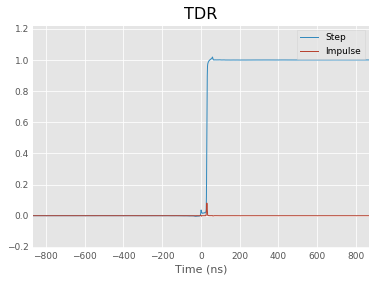

In [8]:
plt.figure()
plt.title('TDR')
t, y = probe_dc.s11.step_response(pad=2000)
t2, y2 = probe_dc.s11.impulse_response(pad=2000)
plt.plot(t*1e9, y, label='Step')
plt.plot(t2*1e9, y2, label='Impulse')
plt.legend()
plt.xlabel('Time (ns)')
plt.show(block=True)

# The end!

In [9]:
sark110.close()